# Bilevel Scalar VI Optimization
This notebook will perform an optimization of a scalar parameter on a variational inequality of the second kind
$$
\min \|\bar{y}-z\|^2 + \frac{\alpha}{2}\|x\|^2\\
\text{s.t. }\langle A\bar{y},v-\bar{y} \rangle + g\|v\|_1 - g\|\bar{y}\|_1 \ge \langle x,v-\bar{y} \rangle
$$

where $\mathbb{R}^n\ni \bar{y} = S(u)\in \mathbb{R}^n$ is the solution operator of the variational inequality

In [1]:
using LinearAlgebra, StructuredOptimization, Plots, Distributed

## Cost Function and Lower Level Solver

In [2]:
# Lower Level Solver
function lower_level_solver(A,x,y,g)
    @minimize ls(A*y - x) + g*norm(y,1)
    return ~y
end

# Upper level cost
function upper_level_cost(x,y,z,alpha)
    return 0.5*norm(y-z)^2 + 0.5*alpha*norm(x)^2
end

upper_level_cost (generic function with 1 method)

In [3]:
A, x = 1, 1.0;
z = 3.0
g = 3.0
alpha = 0.1
y = Variable(1)
y_h = lower_level_solver(A,x,y,g)
println(typeof(y_h))
c = upper_level_cost(x,y_h[1],z,alpha)
println("$y_h, $c")

Array{Float64,1}
[0.0], 4.55


In [4]:
x_range = 0.1:0.1:7;

costs = Float64[]
@distributed for x in x_range
    y_h = lower_level_solver(A,x,y,g)
    c = upper_level_cost(x,y_h[1],z,alpha)
    push!(costs,c)
    #println("$x $y_h $c")
end

Task (done) @0x0000000128fe18d0

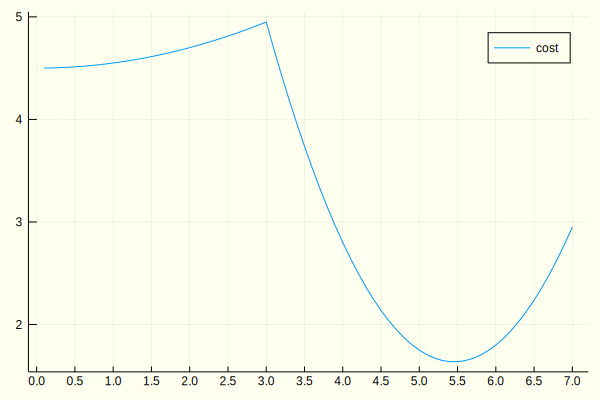

In [13]:
plot(x_range,costs,label="cost",xticks = 0:0.5:7, background_color = :ivory)

## Gradient Calculation
In the case of an empty biactive set, we know the the solution operator is Gateaux differentiable, and the directional derivative of $S(x)$ in direction $h$, $\eta = S'(x)h$ is the solution of the following system of equations
$$
\eta_i = 0,\;\text{ for }i:\;y_i = 0,\\
\sum_{i\in\mathcal{I}} A_{i,j}\eta_j= h_i,\;\text{ for }i:\;y_i = 0.
$$
Using this result, we can characterize a reduced cost function
$$
j(x) = \frac{1}{2}\|S(x)-z\|^2 + \frac{\alpha}{2}\|x\|^2,
$$
and its directional derivative given by
$$
\begin{align}
j'(x)h &= \langle S(x)-z,S'(x)h \rangle + \alpha \langle x,h \rangle,\\
&= \sum_i (y_i-z_i)\eta_i + \alpha\sum_i x_ih_i
\end{align}
$$
Defining the adjoint state $p\in\mathbb{R}^n$ as
$$
p_j = y_j-z_j,\;j\in\mathcal{I},\\
p_j = 0,\;j\not\in\mathcal{I}.
$$

In [6]:
function adjoint(y,z)
    p = 0
    if norm(y) .> 1e-3
        p = y - z
    end
    return p
end

function gradient(x,y,z,alpha)
    grad = alpha*x
    p = adjoint(y,z)
    if norm(y) .> 1e-3
        grad = p + grad
    end
    return grad
end
        

gradient (generic function with 1 method)

In [8]:
x_range = 0.1:0.1:7;

grads = Float64[]
@distributed for x in x_range
    y_h = lower_level_solver(A,x,y,g)
    grad = gradient(x,y_h[1],z,alpha)
    push!(grads,grad)
    #println("$x $y_h $c")
end

Task (done) @0x00000001175a7190

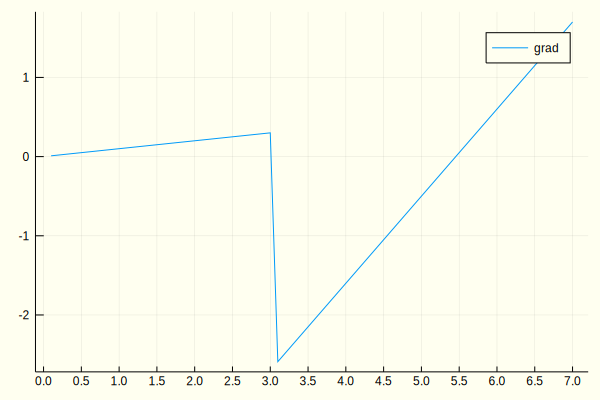

In [14]:
plot(x_range,grads,label="grad",xticks = 0:0.5:7, background_color = :ivory)